#  WGU MSDA D213 Advanced Analytics Task 2 - Sentiment Analysis Using Neural Networks Revision

## Jan Francis Mitchell Barlaan

### A1: Research Question

* My question for this analysis is can we discern whether customer sentiments conveyed in movie reviews are positive or negative? Based on industry applications of similar datasets, I believe that the answer to this is yes (Al-Ma'arif, Sentiment Analysis in action: A case study with movie reviews using NLP techniques 2024). We will support my assumption with the results of this analysis.

### A2: Objectives or Goals


* My objective is to build a model that can predict viewer sentiments based on their words chosen in written reviews.

### A3: Prescribed Network


* I have chosen to create my model based on sequential text classification. This type of model is considered a recurrent neural network (RNN). RNNs can be trained to make predictions based on the sentiments and sequences of text present in our starting dataset (Asomani, Movie Review Sentimental Classification with recurrent neural network in TENSORFLOW 2023).

### B1: Data Exploration
* EDA was performed after importing the necessary packages for this analysis. Nulls and value counts of the columns were detected for as well as the shape and information that the dataframe contained.

In [1]:
# Import initial necessary packages 

import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.model_selection import train_test_split

import re

import tensorflow as tf

import keras


#Used to convert input text to tokens
from tensorflow.keras.preprocessing.text import Tokenizer


#Used to stop training at a threshold
from tensorflow.keras.callbacks import EarlyStopping


#Used for loading a saved model
from tensorflow.keras.models import load_model


from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential

#Used for padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences 


import warnings
warnings.filterwarnings("ignore")




In [2]:
# Load the text file as csv

imbd_df = pd.read_csv(r'C:\Users\neoka\OneDrive\Desktop\WGU MSDA Course Material\D213\sentiment+labelled+sentences\sentiment labelled sentences\imdb_labelled.txt', header=None, names=['Reviews', 'Sentiment'], sep='\t|\r', quoting=csv.QUOTE_NONE) 



In [3]:
# Save the imbd dataframe to csv

imbd_df.to_csv('imbd_df.csv', index=False)

In [4]:
# Establish df alias for imbd_df

df = imbd_df

In [5]:
# Examine dataframe

df

,Reviews,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [6]:
# Validates the structure and displays the first 5 rows of the new dataframe  

df.head()

,Reviews,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
# Shows the number of observations and variables (rows and columns)

df.shape

(1000, 2)

In [8]:
# Shows information about the dataframe such as types, etc.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [9]:
#Count of null/missing values in each column

df.isnull().sum()

Reviews      0
Sentiment    0
dtype: int64

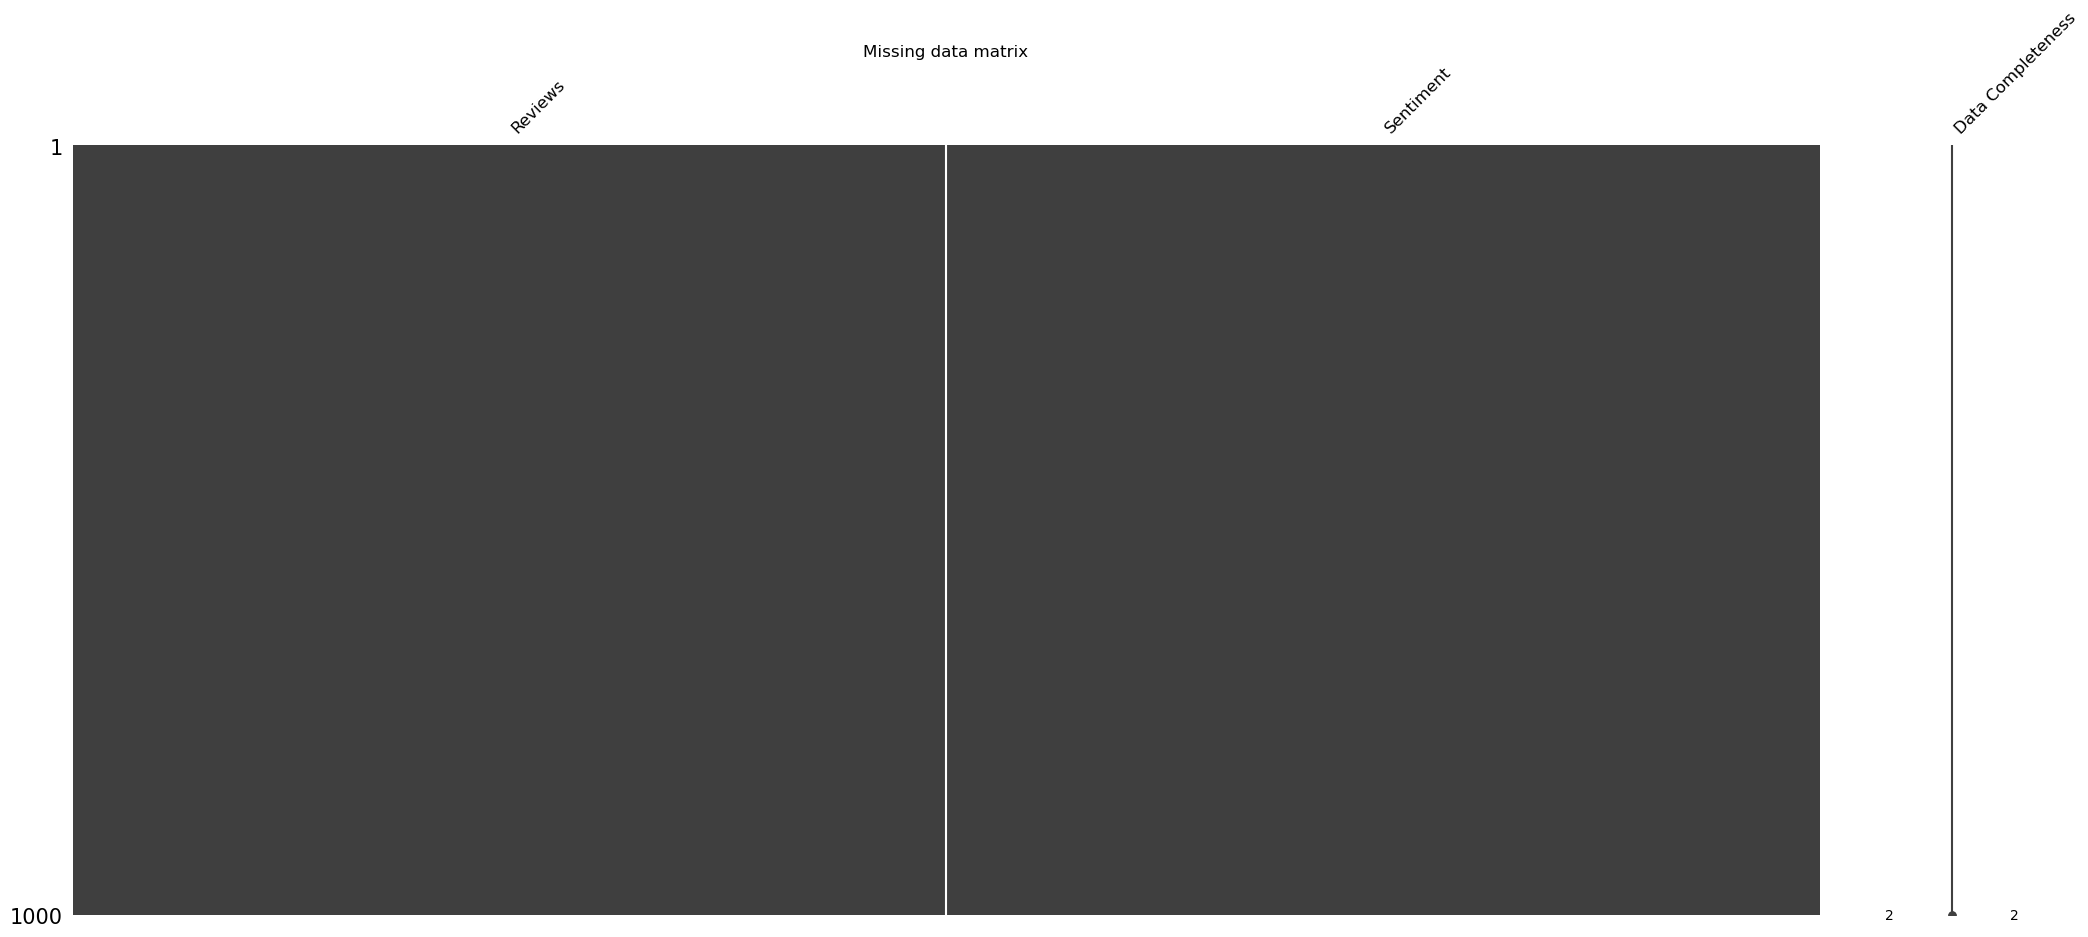

In [10]:
#Import missingno to visualize missing/null values 

import missingno as msno
msno.matrix(df, fontsize=12, labels=True)
plt.title('Missing data matrix')
plt.show()


In [11]:
# Define a positive sentiment (1) and a negative sentiment (0)

# 1 = positive sentiment, 0 = negative sentiment
print(df['Sentiment'].value_counts())


0    500
1    500
Name: Sentiment, dtype: int64


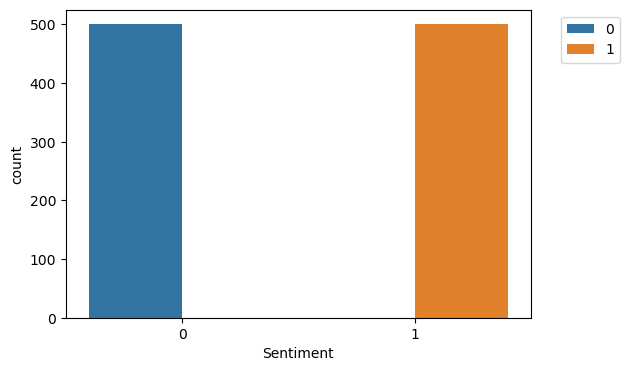

In [12]:
#Plot the value counts
# 1 represents a positive sentiment, while 0 represents a negative sentiment

plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', hue='Sentiment', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

* The following lines of code are adapted from Dr. Elleh and an article on Medium. The code removes these characters and converts reviews to all lowercase, tokenizes & lemmatizes reviews, & removes stopwords (Asomani, Movie Review Sentimental Classification with recurrent neural network in TENSORFLOW 2023). 

#### B1a: Presence of unusual characters
* We detected for unusual characters and changed capital letters to lowercase. Tokenization, lemmatization, and stopword removal was also included in the 'for' loop


In [13]:
# Identify all characters contained in the reviews column
commentary = df['Reviews']
list_of_characters = []
for comment in commentary: 
    for character in comment:
        if character not in list_of_characters:
            list_of_characters.append(character)
print(list_of_characters)

['A', ' ', 'v', 'e', 'r', 'y', ',', 's', 'l', 'o', 'w', '-', 'm', 'i', 'n', 'g', 'a', 'b', 'u', 't', 'd', 'f', '.', 'N', 'h', 'c', 'k', 'p', '&', 'x', 'V', 'T', 'G', 'I', "'", 'W', 'S', 'L', 'J', 'B', 'F', 'M', 'H', 'C', '"', '\x96', 'z', '?', 'q', 'Y', 'j', 'P', 'U', 'R', 'E', '1', '3', ';', '/', 'O', '2', '9', '0', ':', '*', 'D', 'Q', 'é', '(', ')', '!', 'K', '$', '7', '5', 'Z', '\x85', '8', '+', '%', '4', 'å', '6', '\x97', 'X']


* There are various special and unusual characters detected. The entire list of such characters can be seen in the output of the code above. The special characters are ones that are explicitly not the characters in this specific range 'a-zA-Z'. This range will appear again below to remove all of the aforementioned unusual and special characters

In [14]:
import nltk
from nltk.corpus import stopwords


# Create an empty list to store cleaned reviews
description_list = []

# Define the list of stopwords, specifying English as the language
stop_words = stopwords.words('english')

# Special/unusual characters will be removed by iterating over a for loop
for description in df['Reviews']: 
    
#Regular Expression can remove special characters from the string. 
#It will be in the form [^a-zA-Z0-9], where ^ represents any character except the characters in the brackets, 
##and a-zA-Z0-9 represents that string can only have small and capital alphabets and numerical digits. 
    description = re.sub("[^a-zA-Z]", " ", description) 
#Convert to lower case
    description = description.lower()
#Perform tokenization
    description=nltk.word_tokenize(description)
#Perform lemmatization
    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
#Removing stopwords
    description = [word for word in description if not word in stop_words]
    description = " ".join(description)
    description_list.append(description)
        

In [15]:
# The cleaned reviews are now stored in description_list
# Create a dataframe out of this list:
description_df = pd.DataFrame(description_list, columns=['CleanReviews'])

# Append Sentiments from the original dataframe to this new dataframe
description_df = pd.concat([description_df, df['Sentiment']], axis=1)

description_df.head()

,CleanReviews,Sentiment
0,slow moving aimless movie distressed drifting ...,0
1,sure wa lost flat character audience nearly ha...,0
2,attempting artiness black white clever camera ...,0
3,little music anything speak,0
4,best scene movie wa gerardo trying find song k...,1


In [16]:
#Displaying stop words

stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [17]:
# Identify vocabulary size

tokenizer = Tokenizer()
tokenizer.fit_on_texts(description_df['CleanReviews'])

word_count = len(tokenizer.word_index) +1

print("Vocabulary_size: ", word_count)

Vocabulary_size:  2719


#### B1b: Vocabulary size
* Listed above is our vocabulary size of 2719 that we discovered after running our code. This number represents the count of unique/tokenized words found across all reviews.

In [18]:
# Determine min, med, and max lengths of reviews 


review_length = []
for char_len in description_df['CleanReviews']:
    review_length.append(len(char_len.split(" ")))

review_max = np.max(review_length)
review_min = np.min(review_length)
review_median = np.median(review_length)

print("Max length of sequences is:", review_max)
print("Min length of sequences is:", review_min)
print("Median length of sequences is:", review_median)

# The median review length will be used as the proposed word embedded length here: 
print()
print("Proposed word embedding length:", review_median)

Max length of sequences is: 44
Min length of sequences is: 1
Median length of sequences is: 6.0

Proposed word embedding length: 6.0


#### B1c: Proposed word embedding length
* Listed above is our proposed word embedding length of 6.0 based on the review median length.

In [19]:
# Our maximum sequence length was established in the prior cell with this code line:

print("Max length of sequences is: ", review_max)

Max length of sequences is:  44


#### B1d: Statistical justification for chosen maximum sequence length
* Listed above is our maximum sequence length of 44, justified by the review_max function 

### B2: Tokenization
* Tokenization is used to simplify text data analyzation so that a machine model can utilize the data while retaining the context. It works by breaking down text strings into tokens, which are smaller components of the original data. It is also an important step in preprocessing since it aids in the identification and removal of both stopwords and unnecessary characters.


* Certain portions of the code in this section are adapted from Geeksforgeeks (GeeksforGeeks, Training of recurrent neural networks (RNN) in tensorflow 2025).

In [20]:
# Tokenization on the cleaned dataset

tokenizer = Tokenizer()
tokenizer.fit_on_texts(description_df['CleanReviews'])

word_count = len(tokenizer.word_index) + 1

print("Number of unique words:", word_count)

Number of unique words: 2719


In [21]:
# Display the list of all word tokens from the cleaned dataset

from nltk.tokenize import word_tokenize


description_df['CleanReviews'].apply(word_tokenize)

0      [slow, moving, aimless, movie, distressed, dri...
1      [sure, wa, lost, flat, character, audience, ne...
2      [attempting, artiness, black, white, clever, c...
3                       [little, music, anything, speak]
4      [best, scene, movie, wa, gerardo, trying, find...
                             ...                        
995    [got, bored, watching, jessice, lange, take, c...
996    [unfortunately, virtue, film, production, work...
997                                 [word, embarrassing]
998                                 [exceptionally, bad]
999      [insult, one, intelligence, huge, waste, money]
Name: CleanReviews, Length: 1000, dtype: object

In [22]:
# Tokenized original dataframe for comparison to our tokenized cleaned dataframe

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Reviews'])

word_count = len(tokenizer.word_index) + 1

print("Number of unique words:", word_count)

Number of unique words: 3134


In [23]:
#  Display the list of all word tokens from the original dataset

df['Reviews'].apply(word_tokenize)

0      [A, very, ,, very, ,, very, slow-moving, ,, ai...
1      [Not, sure, who, was, more, lost, -, the, flat...
2      [Attempting, artiness, with, black, &, white, ...
3      [Very, little, music, or, anything, to, speak,...
4      [The, best, scene, in, the, movie, was, when, ...
                             ...                        
995    [I, just, got, bored, watching, Jessice, Lange...
996    [Unfortunately, ,, any, virtue, in, this, film...
997            [In, a, word, ,, it, is, embarrassing, .]
998                              [Exceptionally, bad, !]
999    [All, in, all, its, an, insult, to, one, 's, i...
Name: Reviews, Length: 1000, dtype: object

* As we can observe, words such as 'a', 'an', 'the', etc. are not present in the tokenized clean dataframe. These have been removed since they provide no value as inputs in the RNN model.

### B3: Padding process
* Padding is the process in which data that is variable in length is made uniform through either the removal or addition of characters in a string. As evident in the chosen parameters in the code below, padding and truncating were both applied post, meaning that it padded and truncated after the text sequence using the pad_sequences function. 

In [24]:
# Applying padding 

# This converts description_list to a list of integers using texts_to_sequences

# First, tokenize the description list
sequences = tokenizer.texts_to_sequences(description_list)

# Next, pad after the text sequence by specifying 'post' for both padding and truncating
padded_sequence = pad_sequences(sequences, padding = 'post', truncating = 'post', maxlen = review_max)

padded_sequence

array([[ 286,  406, 1216, ...,    0,    0,    0],
       [ 521,  408,  735, ...,    0,    0,    0],
       [1220, 1221,  208, ...,    0,    0,    0],
       ...,
       [ 360,  574,    0, ...,    0,    0,    0],
       [3132,   24,    0, ...,    0,    0,    0],
       [ 507,   19,  489, ...,    0,    0,    0]])

In [25]:
# Output our padded sequence to text

to_words = tokenizer.sequences_to_texts(padded_sequence)
to_words

['slow moving aimless movie distressed drifting young man',
 'sure lost flat character audience nearly half walked',
 'attempting artiness black white clever camera angle movie disappointed became even ridiculous acting poor plot line almost non existent',
 'little music anything speak',
 'best scene movie gerardo trying find song keep running head',
 'rest movie lack art charm meaning emptiness work guess empty',
 'wasted two hour',
 'saw movie today thought good effort good',
 'bit predictable',
 'loved casting jimmy buffet science teacher',
 'baby adorable',
 'movie showed lot florida best made look appealing',
 'song best muppets hilarious',
 'cool',
 'right case movie delivers everything almost right face',
 'average acting main person low budget clearly see',
 'review long overdue since consider tale two sister single greatest film ever made',
 'put gem movie screenplay cinematography acting post production editing directing aspect film making',
 'practically perfect true masterp

#### Padded Sequence Example
* Displayed in the two cells above are a padded sequence and the same padded sequence in text form.

### B4: Categories of sentiment
* Our categories for sentiment are shown below with the chart displayed earlier. 0 represents a negative sentiment, while 1 represents a positive sentiment. The countplot below visualizes this distribution.
* The sigmoid activation function was chosen since it is an appropriate choice when dealing with binary classification problems such our sentiment analysis. The cell following the countplot shows the code where the sigmoid activation function is specified in the final dense layer of the model.

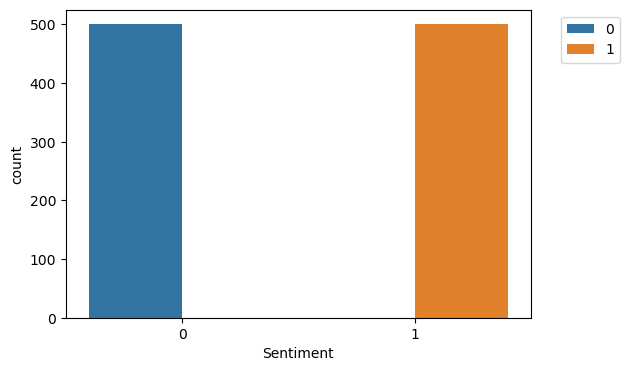

In [26]:
#Plot the value counts
# 1 represents a positive sentiment, while 0 represents a negative sentiment


plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', hue='Sentiment', data=description_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [30]:
# Creating the model. Code is adapted from Dr. Elleh and slightly modified to specify an Input layer and the addition of a Bidirectional LSTM layer

#Batch size 100 and epochs set to 20

activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'adam' 
num_epochs = 20

# Define early stopping monitor and checkpoint
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(int(review_max),)), 
    tf.keras.layers.Embedding(word_count, review_max, input_length=review_max),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(64)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation=activation)
])

# Compilation of our model. The metric we have chosen is accuracy
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])


# Summary statistics of our model
model.summary()


history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test), 
                    callbacks=[early_stop, checkpoint], verbose=True)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 44, 44)         │       137,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        55,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,756 (827.17 KB)

 Trainable params: 211,756 (827.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 658ms/step - accuracy: 0.5163 - loss: 0.6930 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.6265 - loss: 0.6901 - val_accuracy: 0.5700 - val_loss: 0.6902
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.6327 - loss: 0.6800 - val_accuracy: 0.5450 - val_loss: 0.6841
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.6979 - loss: 0.6456 - val_accuracy: 0.5850 - val_loss: 0.6704
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.7535 - loss: 0.5761 - val_accuracy: 0.6150 - val_loss: 0.6383
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.8776 - loss: 0.4339 - val_accuracy: 0.7650 - val_loss: 0.5130
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9422 - loss: 0.2283 - val_accuracy: 0.7900 - val_loss: 0.4628
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.9664 - loss: 0.1215 - val_accuracy: 0.7750 - val_loss

### B5: Steps to prepare the data
* Necessary packages and the beginning dataset were imported
* EDA was performed
* Data cleaning was performed
* Vocabulary size was determined
* Proposed word embedding length was determined
* Maximum sequence length was determined
* Data tokenization
* Data padding
* Determined the number of categories
* Data was split into training and test sets
* Train, test, and whole cleaned data sets were saved into individual csv files

### B6: Prepared Data Set
* Listed below is the final prepared data set along with individual sets for the train and test sets for both X and y components. Therefore, there are a total of 5 final data sets in csv format.

In [27]:
#Split the data into train and test sets. 80:20 split

#Define X and y
X = padded_sequence

# Generate the output labels y
y = description_df[['Sentiment']].values

# 80:20 train:test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)



In [28]:
# With y_test and y_train defined, y can be one-hot encoded.

from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [29]:
#Save train and test data to csv:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)


X_train_df.to_csv('X_train_df.csv', index=False)
X_test_df.to_csv('X_test_df.csv', index=False)
y_train_df.to_csv('y_train_df.csv', index=False)
y_test_df.to_csv('y_test_df.csv', index=False)

#Save cleaned df (description_df) to csv
description_df = pd.DataFrame(description_df)

description_df.to_csv('description_df.csv', index=False)

### C1: Model Summary
* Keras/Tensorflow is used to create the model. The code to set the model parameters and instantiate it is displayed below. The model output and its summary is also included. The code below is modified from the one provided by Dr. Elleh in his lectures and presentations (Elleh, n.d.).


* As seen in the output below, there are a total of 211,756 parameters. The type of RNN chosen is a sequential model with various layers, including a specified Input Layer, an Embedding Layer, a Bidirectional LSTM Layer, a Dense Layer with relu activation, a Dropout Layer, another Dense Layer with relu activation, and a final Dense Layer with a sigmoid activation layer.


* Certain portions of code such as those in the LSTM layer and the callbacks have been adapted from a Medium article (Luay, 2023).

In [30]:
# Creating the model. Code is adapted from Dr. Elleh and slightly modified to specify an Input layer and the addition of a Bidirectional LSTM layer

#Batch size 100 and epochs set to 20

activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'adam' 
num_epochs = 20

# Define early stopping monitor and checkpoint
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(int(review_max),)), 
    tf.keras.layers.Embedding(word_count, review_max, input_length=review_max),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(64)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation=activation)
])

# Compilation of our model. The metric we have chosen is accuracy
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])


# Summary statistics of our model
model.summary()


history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test), 
                    callbacks=[early_stop, checkpoint], verbose=True)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 44, 44)         │       137,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        55,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,756 (827.17 KB)

 Trainable params: 211,756 (827.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 658ms/step - accuracy: 0.5163 - loss: 0.6930 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.6265 - loss: 0.6901 - val_accuracy: 0.5700 - val_loss: 0.6902
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.6327 - loss: 0.6800 - val_accuracy: 0.5450 - val_loss: 0.6841
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.6979 - loss: 0.6456 - val_accuracy: 0.5850 - val_loss: 0.6704
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.7535 - loss: 0.5761 - val_accuracy: 0.6150 - val_loss: 0.6383
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.8776 - loss: 0.4339 - val_accuracy: 0.7650 - val_loss: 0.5130
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9422 - loss: 0.2283 - val_accuracy: 0.7900 - val_loss: 0.4628
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.9664 - loss: 0.1215 - val_accuracy: 0.7750 - val_loss

### C2: Network Architecture: 

#### There are 6 layers that compose the network 


* Layer 1: Embedding parameters:  137,896

* Layer 2: Bidirectional parameters: 55,808

* Layer 3: Dense parameters: 12,900

* Layer 4: Dropout parameters: 0

* Layer 5: Dense parameters: 5,050

* Layer 6: Dense parameters: 102

#### There are a total number of 211,756 parameters, which are all trainable.

### C3: Hyperparameters

#### C3a: Activation functions
* Sigmoid was chosen for our activation function since it is best suited for binary data

#### C3b: Number of nodes per layer
* There are 4 layers that contain nodes. The first layer containing nodes is a Bidirectional LSTM Layer containing 64 units por nodes. The first of the Dense Layers contains 100 nodes, the second has 50 nodes, and the third contains 2 nodes. 

#### C3c: Loss function
* Sentiment values being binary led me to choose binary crossentropy as the best loss function.

#### C3d: Optimizer
* Adam is commonly used as the optimization algorithm due to its efficiency and ease of implementation.

#### C3e: Stopping criteria
* Stopping criteria is employed so that overfitting does not occur on the training set. This can lead to high training accuracy but low test accuracy. The patience was set to 3 so that the model will not exceed running 3 times without a noticeable improvement to the model. Training will stop if there is no model improvement within the set limit discussed prior.

#### C3f: Evaluation metric
* The model accuracy is calculated with the code below. I have calculated the accuracies for both the training and test sets.

In [31]:
# Model accuracy - test data: 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', {score[1]})

Test accuracy: {0.7850000262260437}


In [32]:
# For comparison, model accuracy of the train data:  
score = model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', {score[1]})

Train accuracy: {0.987500011920929}


### D1: Stopping Criteria
* Establishing stopping criteria helps to prevent overfitting. The stopping criteria is set to 3. Therefore, the model will not run past 3 consecutive times if there is no observed improvement. The parameter for epochs has been set to 20, therefore, the model will run for 20 iterations before stopping. However, this maximum number of 20 may not be hit if the stopping criteria is met first, since that is given precedence over the number of epochs set. 


### D2: Fitness
* The model fitness was based on the chosen criteria of accuracy. Model accuracy for both the train and test sets were computed with the following code in the cells below. As previously mentioned, we established stopping criteria, which helps to prevent overfitting. The stopping criteria is set to 3. Therefore, the model will not run past 3 consecutive times if there is no observed improvement. The parameter for epochs has been set to 20, therefore, the model will run for 20 iterations before stopping. However, this maximum number of 20 may not be hit if the stopping criteria is met first, since that is given precedence over the number of epochs set.
* Additionally, I incorporated a Dropout Layer. I specified a Dropout of 0.1, meaning 10% of the neurons are randomly turned off. This means they don’t contribute to the forward and backward passes for that particular batch. This layer prevents the model from relying too heavily on any specific neuron, promoting a more distributed and collaborative effort among neurons. It also introduces noise during training, discouraging any neuron from fitting too closely to the training data. 


* Most specifically, our model fitness was assessed on its test accuracy as seen below. The train accuracy has been included for comparison purposes

In [33]:
# Model accuracy - test data: 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', {score[1]})

Test accuracy: {0.7850000262260437}


In [34]:
# For comparison, model accuracy of the train data:  
score = model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', {score[1]})

Train accuracy: {0.987500011920929}


### D3: Training Process
* Keras/Tensorflow was used to create the model. The code to set the model parameters and instantiate it is displayed in Section C1
* Separate history graphs have been generated to show the model accuracy and loss


In [30]:
# This is the exact same code used in section C1


#Batch size 100 and epochs set to 20

activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'adam' 
num_epochs = 20

# Define early stopping monitor and checkpoint
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(int(review_max),)), 
    tf.keras.layers.Embedding(word_count, review_max, input_length=review_max),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(64)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation=activation)
])

# Compilation of our model. The metric we have chosen is accuracy
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])


# Summary statistics of our model
model.summary()


history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test), 
                    callbacks=[early_stop, checkpoint], verbose=True)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 44, 44)         │       137,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        55,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,756 (827.17 KB)

 Trainable params: 211,756 (827.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 658ms/step - accuracy: 0.5163 - loss: 0.6930 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.6265 - loss: 0.6901 - val_accuracy: 0.5700 - val_loss: 0.6902
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.6327 - loss: 0.6800 - val_accuracy: 0.5450 - val_loss: 0.6841
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.6979 - loss: 0.6456 - val_accuracy: 0.5850 - val_loss: 0.6704
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.7535 - loss: 0.5761 - val_accuracy: 0.6150 - val_loss: 0.6383
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.8776 - loss: 0.4339 - val_accuracy: 0.7650 - val_loss: 0.5130
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9422 - loss: 0.2283 - val_accuracy: 0.7900 - val_loss: 0.4628
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.9664 - loss: 0.1215 - val_accuracy: 0.7750 - val_loss

* The following code for both accuracy and loss plots was adapted from the Sentiment Analysis Presentation provided by WGU (WGU, n.d.).

#### Plot of Accuracy & Plot of Loss

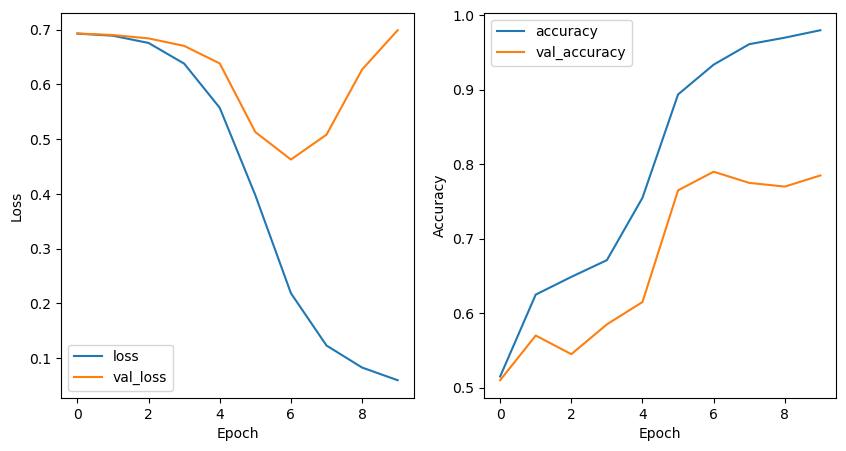

In [36]:

# Plotting the history 
metrics = history.history 
plt.figure(figsize=(10, 5)) 

# Plotting training and validation loss 
plt.subplot(1, 2, 1) 
plt.plot(history.epoch, metrics['loss'], metrics['val_loss']) 
plt.legend(['loss', 'val_loss']) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 

# Plotting training and validation accuracy 
plt.subplot(1, 2, 2) 
plt.plot(history.epoch, metrics['accuracy'], 
metrics['val_accuracy']) 
plt.legend(['accuracy', 'val_accuracy']) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

plt.show()

### D4: Predictive Accuracy
* The model's predictive accuracy is its calculated test accuracy, which is 0.785. This means that about 78.5% of the time, the model can predict whether a customer movie review is conveying a positive or negative sentiment,

In [37]:
# Model accuracy - test data: 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', {score[1]})

Test accuracy: {0.7850000262260437}


### E: Code
* The following code is used to saved the trained network within the neural network.


In [38]:
model.save('SentimentAnalysisModel.keras')

### F: Functionality
* This dataset used to create this model is composed of 1,000 rows of film reviews. The model was trained on 80% of the overall dataset and tested on the remaining 20%. The constructed model was able to predict sentiment with an accuracy of about 98.8% on the train set and about 78.5% on the test set. The overall neural network architecture as well as the chosen set of hyperparameters contributed to these scores. 
* Subjectively, I believe that the neural network is moderately effective at performing the sentiment analysis that I tasked it with, achieving an accuracy of about 78.5% on the test set. However, the loss value of the best model is quite high, around  0.6990. This is an indication that the correctness of its predictions does not have high confidence. Further optimization is certainly possible to increase the accuracies but is beyond the scope of this assigment. Ultimately, I can conclude that the current model provides for a successful sentiment analysis.



### G: Recommendations
* Based on our research question, yes, we  can use this model to discern whether sentiments based on movie reviews are positive or negative. However, our rather high loss value of 0.6990 mentioned prior might lead to poor precision. 
* Our current model is essentially one with moderate/high accuracy but low precision. I suggest that improving the training set and optimizing the parameters of the model and even experimenting with different model variations would certainly provide models with high/higher accuracy and lower loss values/higher precision. Additionally, a larger dataset to train the model on would prove beneficial since our working set of 1000 observations is still quite small in comparison to other sets frequently used in real-life scenarios. Overall, I think that this model is a good starting point and is feasible enough to be implemented on other test sets.  

### H: Reporting
* This report in its entirety will be attached in its original .ipynb form and as a .pdf file

### I: Sources for Third-Party Code 
* D213 Sentiment Analysis Presentation _ 3_default_da1cc82b [Webinar]. WGU. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=fe172002-6cbb-40c0-92a3-b07d01025504
* Elleh, F. D213 Task 2 Cohort Webinar [PowerPoint Slides].
* GeeksforGeeks. (2025, February 27). Training of recurrent neural networks (RNN) in tensorflow. https://www.geeksforgeeks.org/training-of-recurrent-neural-networks-rnn-in-tensorflow/ 
* Luay, M. (2023, September 22). Sentiment analysis using recurrent neural network(rnn),long short term memory(lstm) and... Medium. https://medium.com/@muhammadluay45/sentiment-analysis-using-recurrent-neural-network-rnn-long-short-term-memory-lstm-and-38d6e670173f 

### J: Sources
* Al-Ma’arif, Q. (2024, January 21). Sentiment Analysis in action: A case study with movie reviews using NLP techniques. Medium. https://medium.com/@datailm/sentiment-analysis-in-action-a-case-study-with-movie-reviews-using-nlp-techniques-52f7fe26206d 
* Asomani, K. (2023, August 1). Movie Review Sentimental Classification with recurrent neural network in TENSORFLOW. Medium. https://medium.com/@kwasiasomani85/movie-review-sentimental-classification-with-recurrent-neural-network-in-tensorflow-3c0ce1c1fea6 
* Elleh, F. D213 Task 2 Cohort Webinar [PowerPoint Slides].
